# Creation of the Spark Session and Context

In [123]:
spark.stop()

In [105]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType

# PySpark functions
from pyspark.sql.functions import (
    col, lag, expr, when, count, sum as sum_, abs as abs_, round as spark_round,
    min as spark_min, max as spark_max, avg as spark_avg, min_by,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    first, desc, asc
)

In [1]:
os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

spark = SparkSession.builder \
    .appName("MAPDProject") \
    .master("spark://10.67.22.135:7077") \
    .config("spark.scheduler.mode", "FAIR") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.shuffle.service.enabled", "false") \
    .config("spark.scheduler.pool", "user_b") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 09:11:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Dataset upload and partition

In [2]:
Npartition = 16 # to change (one of project goal)

In [3]:
df = spark.read.option("header", True).csv("file:///mnt/shared/dataset.csv")
df = df.repartition(Npartition)

25/07/29 09:11:57 WARN FairSchedulableBuilder: A job was submitted with scheduler pool user_b, which has not been configured. This can happen when the file that pools are read from isn't set, or when that file doesn't contain user_b. Created user_b with default configuration (schedulingMode: FIFO, minShare: 0, weight: 1)
                                                                                

In [4]:
print(f"Number of partition used {df.rdd.getNumPartitions()}")

[Stage 1:====================================================>    (36 + 3) / 39]

Number of partition used 16


In [5]:
df.printSchema()

root
 |-- when: string (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)



# Focus on one hardware at time

In [6]:
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

In [7]:
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 4:=============================>                            (8 + 8) / 16]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-065|
|SW-115|
+------+



In [8]:
# CHANGE HERE HARDWARE TO ANALYZE
hardware = "SW-106"
df_hard = df.filter(col("hwid") == hardware)

In [9]:
df_hard.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)



In [10]:
df_hard.show(5, truncate=False)

[Stage 8:=======================================================> (38 + 1) / 39]

+----------+------+------+-----+
|when      |hwid  |metric|value|
+----------+------+------+-----+
|1602780864|SW-106|S178  |0    |
|1602163626|SW-106|S97   |48   |
|1602387248|SW-106|S166  |266  |
|1602411743|SW-106|SW    |1    |
|1602812169|SW-106|S108  |0    |
+----------+------+------+-----+
only showing top 5 rows



In [11]:
df_hard = df_hard.groupBy("when").pivot("metric").agg(first("value"))\
    .withColumn("time", from_unixtime(col("when"))).orderBy("when")

In [12]:
df_hard.printSchema()

root
 |-- when: integer (nullable = true)
 |-- A5: string (nullable = true)
 |-- A9: string (nullable = true)
 |-- ComError: string (nullable = true)
 |-- P1: string (nullable = true)
 |-- P10: string (nullable = true)
 |-- P15: string (nullable = true)
 |-- P16: string (nullable = true)
 |-- P17: string (nullable = true)
 |-- P18: string (nullable = true)
 |-- P2: string (nullable = true)
 |-- P5: string (nullable = true)
 |-- P6: string (nullable = true)
 |-- P7: string (nullable = true)
 |-- P8: string (nullable = true)
 |-- P9: string (nullable = true)
 |-- S1: string (nullable = true)
 |-- S10: string (nullable = true)
 |-- S100: string (nullable = true)
 |-- S101: string (nullable = true)
 |-- S102: string (nullable = true)
 |-- S106: string (nullable = true)
 |-- S107: string (nullable = true)
 |-- S108: string (nullable = true)
 |-- S109: string (nullable = true)
 |-- S11: string (nullable = true)
 |-- S110: string (nullable = true)
 |-- S112: string (nullable = true)
 |-- S113

In [13]:
selected_cols = ["time", "S117", "S118", "S169", "S170"]

In [14]:
# show first 5 rows
df_hard.select(*selected_cols).orderBy(col("time").asc()).show(5)

[Stage 29:================>                                        (5 + 8) / 17]

+-------------------+----+----+----+----+
|               time|S117|S118|S169|S170|
+-------------------+----+----+----+----+
|2020-10-01 00:00:22|   0|   1|NULL|NULL|
|2020-10-01 00:00:25|NULL|NULL|   0|   1|
|2020-10-01 00:00:53|   0|   1|NULL|NULL|
|2020-10-01 00:00:55|NULL|NULL|   0|   1|
|2020-10-01 00:01:23|   0|   1|NULL|NULL|
+-------------------+----+----+----+----+
only showing top 5 rows



In [15]:
# show last 5 rows
df_hard.select(*selected_cols).orderBy(col("time").desc()).limit(5).orderBy(col("time").asc()).show()

[Stage 35:==========================================>             (13 + 4) / 17]

+-------------------+----+----+----+----+
|               time|S117|S118|S169|S170|
+-------------------+----+----+----+----+
|2021-03-27 07:27:36|NULL|NULL|   0|   0|
|2021-03-27 07:28:03|   1|   0|NULL|NULL|
|2021-03-27 07:28:06|NULL|NULL|   0|   0|
|2021-03-27 07:28:34|   0|   0|NULL|NULL|
|2021-03-27 07:28:37|NULL|NULL|   0|   0|
+-------------------+----+----+----+----+



# Timestamp analysis

In [16]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    """
    Computes time differences (Δwhen) between consecutive rows in a DataFrame.

    Args:
        df (DataFrame): Spark DataFrame with a time column (e.g., 'when').
        when_col (str): Name of the time column to compute differences on.
        max_collect (int): Threshold to safely collect diffs to driver.

    Returns:
        rdd_diff (RDD): RDD of differences (current - previous).
    """
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [37]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    """
    Summarizes the RDD of time differences into a frequency table and prints top/bottom values.

    Args:
        rdd_diff (RDD): RDD of integer time differences.
        spark (SparkSession): Active Spark session.
        top_n (int): Number of rows to show from top and bottom.

    Returns:
        df_freq (DataFrame): DataFrame with columns ['diff', 'count'].
    """
    if rdd_diff is None:
        print("No differences available to summarize.")
        return None

    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [38]:
# Compute time differences
rdd_diff = compute_time_differences(df_hard)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 398038

5 smallest time differences:
+----+------+
|diff|count |
+----+------+
|2   |23809 |
|3   |166233|
|4   |5106  |
|5   |464   |
|6   |298   |
+----+------+
only showing top 5 rows


5 largest time differences:
+-------+-----+
|diff   |count|
+-------+-----+
|5003774|1    |
|2066908|1    |
|757864 |1    |
|48451  |1    |
|28598  |1    |
+-------+-----+
only showing top 5 rows



In [19]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    #plt.grid(True)
    plt.show()

In [20]:
diffs = rdd_diff.collect() # check previously the dimension

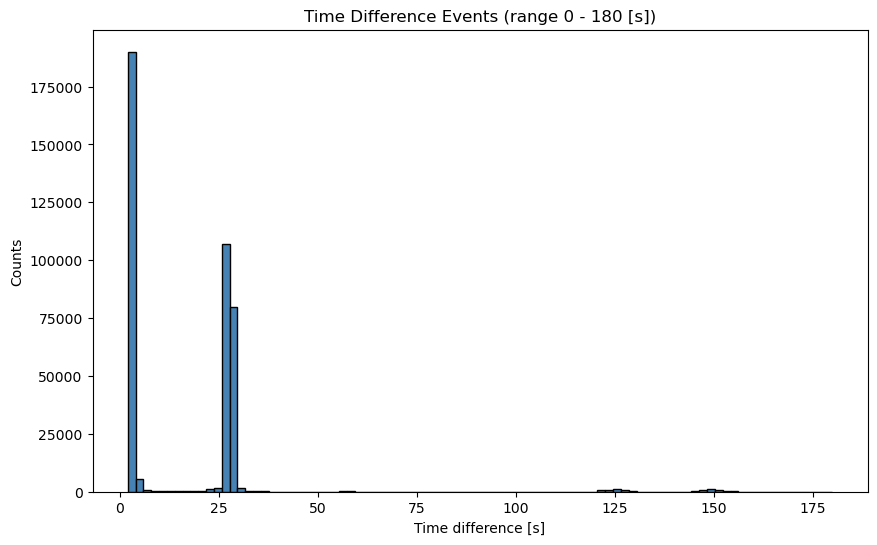

In [21]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

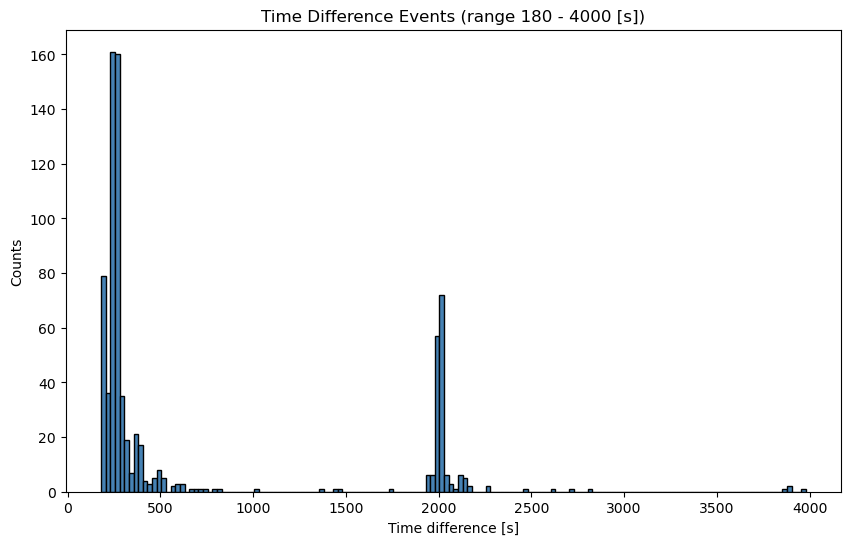

In [22]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=25)

# Handling missing data & gaps

### Prova sull'intero datset

In [23]:
# from pyspark.sql.functions import broadcast, abs as abs_, row_number
# from pyspark.sql.window import Window

# def resample_fast(df_hard, interval=60):
#     #spark = df_hard.sparkSession
#     half = interval / 2

#     # Build tiny time grid and broadcast it
#     min_time, max_time = df_hard.selectExpr("min(when)", "max(when)").first()
#     times = list(range(min_time, max_time + 1, interval))
#     grid_df = spark.createDataFrame([(t,) for t in times], ["target_when"])
#     grid_df = broadcast(grid_df)

#     # Range join on when BETWEEN target_when ± half
#     joined = df_hard.join(
#         grid_df,
#         (df_hard.when >= grid_df.target_when - half) &
#         (df_hard.when <= grid_df.target_when + half),
#         how="inner"
#     )

#     # Pick the nearest row per target_when
#     window_spec = Window.partitionBy("target_when").orderBy(abs_(col("when") - col("target_when")))
#     best = (
#         joined
#           .withColumn("rn", row_number().over(window_spec))
#           .filter(col("rn") == 1)
#           .drop("rn")              # drop row‑number
#           .drop("when")            # DROP original `when`
#           .withColumnRenamed("target_when", "when")  # rename the grid col
#     )

#     return best

# from functools import reduce

# def resample_one_sensor(df_hard, sensor, interval=60):
#     # Select only the timestamp and this single sensor
#     df_sel = df_hard.select("time","when", sensor)
#     return resample_fast(df_sel, interval).select("time","when", sensor)

In [24]:
# INFINITE TIME

# # List of your sensor columns
# sensors = [c for c in df_hard.columns if c not in ("time","when")]

# # Resample each sensor individually
# sensor_dfs = [resample_one_sensor(df_hard, s, 60) for s in sensors]

# # Join them all back on "when"
# df_resampled = reduce(
#     lambda left, right: left.join(right, on="when", how="outer"),
#     sensor_dfs
# ).orderBy("when")

# df_resampled.show(5)

In [25]:
# resample_one_sensor(df_hard, "S117", 60).show(5)

### Su solo una colonna (metodo nearest) FUNZIONANTE

In [40]:
def resample_sensor_simple(
    df_hard: DataFrame,
    sensor: str,
    interval: int = 60
) -> DataFrame:
    """
    Resample a single sensor column to regular intervals using the nearest non-null value.

    Args:
        df_hard:   Spark DataFrame with columns ['when', sensor].
        sensor:    Name of the sensor column (e.g., 'S117').
        interval:  Resample interval in seconds.

    Returns:
        Resampled DataFrame with ['when', sensor, 'time'], using only non-null nearest values.
    """
    spark = df_hard.sparkSession
    half = interval / 2

    # 1. Create target timestamp grid
    bounds = df_hard.selectExpr("min(when) as min_t", "max(when) as max_t").first()
    min_t, max_t = bounds.min_t, bounds.max_t

    grid_df = (
        spark.range(1)
             .selectExpr(f"sequence({min_t}, {max_t}, {interval}) as times")
             .select(explode("times").alias("target_when"))
    )

    # 2. Range join within ±half interval and exclude NULLs before aggregation
    joined = (
        df_hard
          .select("when", sensor)
          .filter(col(sensor).isNotNull())  # <-- filter out nulls before min_by
          .join(
              grid_df,
              (col("when") >= col("target_when") - half) &
              (col("when") <= col("target_when") + half),
              how="inner"
          )
          .withColumn("time_diff", abs_(col("when") - col("target_when")))
    )

    # 3. Pick value with minimum time difference (nearest non-null)
    result = (
        joined.groupBy("target_when")
              .agg(min_by(col(sensor), col("time_diff")).alias(sensor))
    )

    # 4. Format output
    final = (
        result
          .withColumnRenamed("target_when", "when")
          .withColumn("time", from_unixtime(col("when")))
          .orderBy("when")
    )

    return final

In [41]:
df_resampled_S117 = resample_sensor_simple(df_hard, "S117", interval=60)
df_resampled_S117.show(10, truncate=False)

25/07/29 10:06:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 10:07:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
[Stage 487:===================================================>   (16 + 1) / 17]

+----------+----+-------------------+
|when      |S117|time               |
+----------+----+-------------------+
|1601510422|0   |2020-10-01 00:00:22|
|1601510482|0   |2020-10-01 00:01:22|
|1601510542|0   |2020-10-01 00:02:22|
|1601510602|0   |2020-10-01 00:03:22|
|1601510662|0   |2020-10-01 00:04:22|
|1601510722|0   |2020-10-01 00:05:22|
|1601510782|0   |2020-10-01 00:06:22|
|1601510842|0   |2020-10-01 00:07:22|
|1601510902|0   |2020-10-01 00:08:22|
|1601510962|0   |2020-10-01 00:09:22|
+----------+----+-------------------+
only showing top 10 rows



25/07/29 10:07:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

<span style="font-size: 200%">Various checks to show that everything works</span>

In [42]:
# inspect a specific region
start_ts = 1601526622
end_ts   = 1601531000

df_resampled_S117.filter(
    (col("when") >= start_ts) & 
    (col("when") <= end_ts)
).show()

25/07/29 10:07:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 10:07:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+----+-------------------+
|      when|S117|               time|
+----------+----+-------------------+
|1601526622|   0|2020-10-01 04:30:22|
|1601526682|   0|2020-10-01 04:31:22|
|1601526742|   0|2020-10-01 04:32:22|
|1601526862|   0|2020-10-01 04:34:22|
|1601526922|   0|2020-10-01 04:35:22|
|1601526982|   0|2020-10-01 04:36:22|
|1601527042|   0|2020-10-01 04:37:22|
|1601527102|   0|2020-10-01 04:38:22|
|1601527162|   0|2020-10-01 04:39:22|
|1601527222|   0|2020-10-01 04:40:22|
|1601529262|   0|2020-10-01 05:14:22|
|1601529322|   0|2020-10-01 05:15:22|
|1601529382|   0|2020-10-01 05:16:22|
|1601529442|   0|2020-10-01 05:17:22|
|1601529502|   0|2020-10-01 05:18:22|
|1601529562|   0|2020-10-01 05:19:22|
|1601529622|   0|2020-10-01 05:20:22|
|1601529682|   0|2020-10-01 05:21:22|
|1601529742|   0|2020-10-01 05:22:22|
|1601529802|   0|2020-10-01 05:23:22|
+----------+----+-------------------+
only showing top 20 rows



25/07/29 10:07:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

In [35]:
# inspect a specific region
start_ts = 1601526622
end_ts   = 1601531000

df_hard.select("time","when","S117").filter(
    (col("when") >= start_ts) & 
    (col("when") <= end_ts)
).show()

[Stage 299:=====================================================> (38 + 1) / 39]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:30:32|1601526632|   0|
|2020-10-01 04:30:39|1601526639|NULL|
|2020-10-01 04:31:02|1601526662|   0|
|2020-10-01 04:31:05|1601526665|NULL|
|2020-10-01 04:31:33|1601526693|   0|
|2020-10-01 04:31:35|1601526695|NULL|
|2020-10-01 04:32:03|1601526723|   0|
|2020-10-01 04:34:10|1601526850|   0|
|2020-10-01 04:34:13|1601526853|NULL|
|2020-10-01 04:34:41|1601526881|   0|
|2020-10-01 04:34:43|1601526883|NULL|
|2020-10-01 04:35:11|1601526911|   0|
|2020-10-01 04:35:14|1601526914|NULL|
|2020-10-01 04:35:41|1601526941|   0|
|2020-10-01 04:35:45|1601526945|NULL|
|2020-10-01 04:36:11|1601526971|   0|
|2020-10-01 04:36:19|1601526979|NULL|
|2020-10-01 04:36:42|1601527002|   0|
|2020-10-01 04:36:45|1601527005|NULL|
|2020-10-01 04:37:12|1601527032|   0|
+-------------------+----------+----+
only showing top 20 rows



In [44]:
# inspect a specific region
start_ts = 1601527100
end_ts   = 1601529400

df_hard.select("time","when","S117").filter(
    (col("when") >= start_ts) & 
    (col("when") <= end_ts)
).show()

[Stage 503:=====================================================> (38 + 1) / 39]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:38:23|1601527103|NULL|
|2020-10-01 04:38:43|1601527123|   0|
|2020-10-01 04:38:46|1601527126|NULL|
|2020-10-01 04:39:14|1601527154|   0|
|2020-10-01 04:39:17|1601527157|NULL|
|2020-10-01 04:39:44|1601527184|   0|
|2020-10-01 04:39:47|1601527187|NULL|
|2020-10-01 04:40:14|1601527214|   0|
|2020-10-01 04:40:17|1601527217|NULL|
|2020-10-01 04:40:45|1601527245|   0|
|2020-10-01 05:14:00|1601529240|   0|
|2020-10-01 05:14:03|1601529243|NULL|
|2020-10-01 05:14:31|1601529271|   0|
|2020-10-01 05:14:33|1601529273|NULL|
|2020-10-01 05:15:01|1601529301|   0|
|2020-10-01 05:15:04|1601529304|NULL|
|2020-10-01 05:15:31|1601529331|   0|
|2020-10-01 05:15:34|1601529334|NULL|
|2020-10-01 05:16:02|1601529362|   0|
|2020-10-01 05:16:04|1601529364|NULL|
+-------------------+----------+----+
only showing top 20 rows



In [45]:
# Check everything is fine

# Compute time differences
rdd_diff_S117 = compute_time_differences(df_resampled_S117)

# Summarize and print top/bottom time gaps
df_diff_summary_S117 = time_diff_summary(rdd_diff_S117, spark)

25/07/29 10:10:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 10:10:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:11:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:11:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:11:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

Number of time differences: 105888

5 smallest time differences:
+----+-----+
|diff|count|
+----+-----+
|60  |98162|
|120 |4869 |
|180 |2168 |
|240 |283  |
|300 |131  |
+----+-----+
only showing top 5 rows


5 largest time differences:
+-------+-----+
|diff   |count|
+-------+-----+
|5003760|1    |
|2066880|1    |
|757860 |1    |
|51960  |1    |
|28620  |1    |
+-------+-----+
only showing top 5 rows



In [106]:
# questo dai dati di prima, sembra funzionare
# |5003774|1    |
# |2066908|1    |
# |757864 |1    |
# |48451  |1    |
# |28598  |1    |

<span style="font-size: 200%">Filtered data block size</span>

#### Non parallelizzata (sposta tutto in unica partizione)

In [97]:
def count_contiguous_blocks(df: DataFrame, interval: int, col_when: str = "when") -> DataFrame:
    """
    Count contiguous blocks with exact interval spacing in the 'when' column.

    Args:
        df:         Input Spark DataFrame with a 'when' column in seconds.
        interval:   Time interval in seconds (e.g., 60).
        col_when:   Name of the time column (default = 'when').

    Returns:
        Spark DataFrame with:
            - block_length: number of rows in each contiguous block
            - block_count:  how many such blocks exist
    """
    # Window partitioning (avoid single-partition performance issue)
    w = Window.orderBy(col(col_when)).partitionBy()  # still no partition key but avoids warning

    # 1. Calculate time difference between rows
    df_with_diff = df.select(col(col_when)).withColumn(
        "prev", lag(col(col_when)).over(w)
    ).withColumn(
        "diff", col(col_when) - col("prev")
    )

    # 2. Mark the beginning of new blocks
    df_with_flag = df_with_diff.withColumn(
        "is_new_block", (col("diff") != interval) | col("diff").isNull()
    )

    # 3. Assign a block ID
    df_with_block = df_with_flag.withColumn(
        "block_id", sum_(col("is_new_block").cast("int")).over(w)
    )

    # 4. Count how many rows in each block
    block_lengths = (
        df_with_block.groupBy("block_id")
                     .count()
                     .withColumnRenamed("count", "block_length")
    )

    # 5. Count number of blocks per length
    result = (
        block_lengths.groupBy("block_length")
                     .count()
                     .withColumnRenamed("count", "block_count")
                     .orderBy("block_length")
    )

    return result

In [98]:
def plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=1):
    """
    Plots a histogram of block sizes from Spark DataFrame.

    Args:
        df_block_stats: DataFrame with columns [block_length, block_count]
        min_length: Minimum block length to include in the plot
        max_length: Maximum block length to include in the plot
        step: Width of each histogram bar
    """
    # Collect the result to the driver
    data = df_block_stats.collect()

    lengths = [row["block_length"] for row in data]
    counts = [row["block_count"] for row in data]

    plt.figure(figsize=(10, 5))
    plt.bar(lengths, counts, width=step, align="center")
    plt.xlabel("Block Length")
    plt.ylabel("Number of Blocks")
    plt.title("Histogram of Contiguous Blocks")
    plt.xlim(min_length, max_length)
    plt.grid(True)
    plt.show()

In [99]:
# Select only the timestamp column
df_sample = df_resampled_S117.select("when")

# Compute block statistics
block_stats = count_contiguous_blocks(df_sample, interval=60)

# Show the result
block_stats.show()

25/07/29 12:04:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:04:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:04:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:04:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:04:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 12:04:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:04:32 WARN WindowExec: No Partition Defined for Window operation! Moving all 

+------------+-----------+
|block_length|block_count|
+------------+-----------+
|           1|        451|
|           2|        539|
|           3|        477|
|           4|        452|
|           5|        427|
|           6|        404|
|           7|        381|
|           8|        368|
|           9|        338|
|          10|        322|
|          11|        240|
|          12|        252|
|          13|        211|
|          14|        217|
|          15|        202|
|          16|        183|
|          17|        155|
|          18|        175|
|          19|        148|
|          20|        108|
+------------+-----------+
only showing top 20 rows



25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 12:05:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/29 12:05:13 WARN WindowExec: No Partition Defined for Window operation! Moving all 

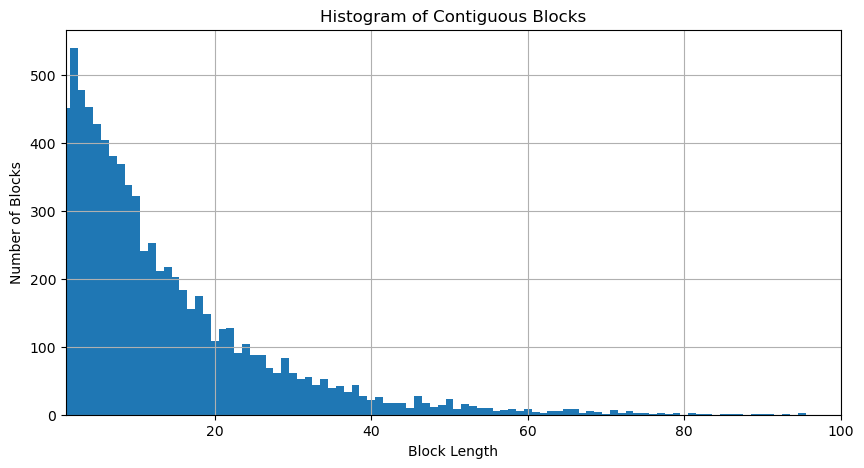

In [100]:
# Plot the histogram
plot_diff_histogram(block_stats, min_length=1, max_length=100)

#### Partiziona con partitionBy("day") -- risultati leggermente diversi, c'è qualcosa che non va --

In [101]:
def count_contiguous_blocks(
    df: DataFrame,
    interval: int,
    col_when: str = "when"
) -> DataFrame:
    """
    Count contiguous blocks of rows spaced exactly `interval` seconds apart,
    partitioned by day for parallelism.

    Args:
      df:         Spark DataFrame with a timestamp column in seconds.
      interval:   Expected spacing between consecutive rows (in seconds).
      col_when:   Name of that timestamp column (default 'when').

    Returns:
      DataFrame with columns:
        - block_length: number of rows in each contiguous block
        - block_count:  how many such blocks exist
    """
    # 1) Add a 'day' column for partitioning
    df2 = df.withColumn("day", to_date(from_unixtime(col(col_when))))

    # 2) Window over each day, ordered by timestamp
    w = Window.partitionBy("day").orderBy(col(col_when))

    # 3) Compute the gap to the previous timestamp
    df3 = (
        df2
        .withColumn("prev_when", lag(col(col_when), 1).over(w))
        .withColumn("gap", col(col_when) - col("prev_when"))
    )

    # 4) Flag start of new block when gap != interval (or first in day)
    df4 = df3.withColumn(
        "is_new_block",
        expr(f"CASE WHEN gap IS NULL OR gap != {interval} THEN 1 ELSE 0 END")
    )

    # 5) Cumulative sum over the window to assign a block_id
    df5 = df4.withColumn(
        "block_id",
        sum_(col("is_new_block")).over(w)
    )

    # 6) Count rows per (day, block_id) → this is block_length
    blocks = (
        df5
        .groupBy("day", "block_id")
        .agg(count("*").alias("block_length"))
    )

    # 7) Count how many blocks have each length across all days
    result = (
        blocks
        .groupBy("block_length")
        .agg(count("*").alias("block_count"))
        .orderBy("block_length")
    )

    return result

In [102]:
def plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=1):
    """
    Plot a histogram of contiguous block lengths.

    Args:
      df_block_stats: Spark DataFrame with ['block_length','block_count']
      min_length:     smallest block_length to include
      max_length:     largest block_length to include
      step:           bar width
    """
    pdf = (
        df_block_stats
        .filter((col("block_length") >= min_length) &
                (col("block_length") <= max_length))
        .orderBy("block_length")
        .toPandas()
    )

    if pdf.empty:
        print("No blocks in the specified range.")
        return

    plt.figure(figsize=(10,5))
    plt.bar(pdf["block_length"], pdf["block_count"], width=step, align="center")
    plt.xlabel("Block Length")
    plt.ylabel("Number of Blocks")
    plt.title("Histogram of Contiguous Block Lengths")
    plt.grid(True)
    plt.xlim(min_length, max_length)
    plt.show()

In [103]:
# 1) Select only the timestamp column
df_sample = df_resampled_S117.select("when")

# 2) Compute contiguous block stats at 60s spacing
block_stats = count_contiguous_blocks(df_sample, interval=60)

# 3) Inspect
block_stats.show()

25/07/29 12:06:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 12:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+------------+-----------+
|block_length|block_count|
+------------+-----------+
|           1|        459|
|           2|        544|
|           3|        491|
|           4|        458|
|           5|        434|
|           6|        407|
|           7|        388|
|           8|        373|
|           9|        346|
|          10|        324|
|          11|        241|
|          12|        260|
|          13|        215|
|          14|        216|
|          15|        200|
|          16|        181|
|          17|        155|
|          18|        175|
|          19|        144|
|          20|        110|
+------------+-----------+
only showing top 20 rows



25/07/29 12:07:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


25/07/29 12:07:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 12:07:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 12:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


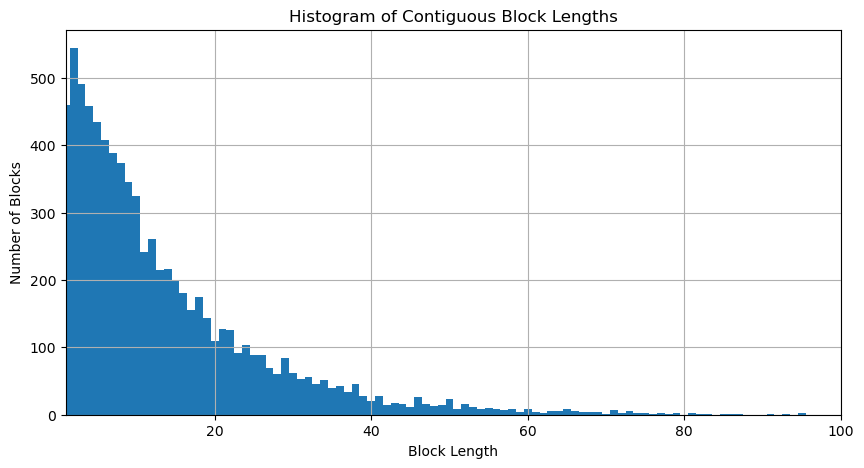

In [104]:
# 4) Plot histogram for blocks length 1–100
plot_diff_histogram(block_stats, min_length=1, max_length=100, step=1)

### Con vari metodi riempimento (near,min,max,mean)

In [52]:
def resample_sensor(
    df_hard: DataFrame,
    sensor: str,
    interval: int = 60,
    method: str = "near"
) -> DataFrame:
    """
    Resample a single sensor column to regular intervals.

    Args:
      df_hard:   DataFrame with 'when' (in seconds) and the sensor column.
      sensor:    name of the sensor column (e.g. 'S117').
      interval:  interval in seconds (e.g. 60).
      method:    one of 'near', 'min', 'max', 'mean'.

    Returns:
      DataFrame with columns ['when', sensor, 'time'] at regular timestamps.
      All values are non-null. If no data is found for a window, the row is skipped.
    """
    spark = df_hard.sparkSession
    half = interval / 2

    # Validate method
    if method not in ("near", "min", "max", "mean"):
        raise ValueError(f"Unsupported method '{method}'. Choose from 'near', 'min', 'max', 'mean'.")

    # 1. Create time grid
    bounds = df_hard.selectExpr("min(when) as min_t", "max(when) as max_t").first()
    min_t, max_t = bounds.min_t, bounds.max_t

    grid_df = (
        spark.range(1)
             .selectExpr(f"sequence({min_t}, {max_t}, {interval}) as times")
             .select(explode("times").alias("target_when"))
    )

    # 2. Join with range ± half interval and exclude NULLs before aggregation
    filtered = df_hard.select("when", sensor).filter(col(sensor).isNotNull())

    joined = (
        filtered
          .join(
              grid_df,
              (col("when") >= col("target_when") - half) &
              (col("when") <= col("target_when") + half),
              how="inner"
          )
          .withColumn("time_diff", abs_(col("when") - col("target_when")))
    )

    # 3. Aggregate based on method
    if method == "near":
        agg_expr = min_by(col(sensor), col("time_diff")).alias(sensor)
    elif method == "min":
        agg_expr = spark_min(col(sensor)).alias(sensor)
    elif method == "max":
        agg_expr = spark_max(col(sensor)).alias(sensor)
    else:  # mean
        agg_expr = spark_avg(col(sensor)).alias(sensor)

    result = (
        joined.groupBy("target_when")
              .agg(agg_expr)
    )

    # 4. Final formatting
    final = (
        result
          .withColumnRenamed("target_when", "when")
          .withColumn("time", from_unixtime(col("when")))
          .orderBy("when")
    )

    return final

In [53]:
# Nearest‐time fill
df_near = resample_sensor(df_hard, "S117", interval=60, method="near")
df_near.show(5)

# Minimum‐value fill
df_min = resample_sensor(df_hard, "S117", interval=60, method="min")
df_min.show(5)

# Maximum‐value fill
df_max = resample_sensor(df_hard, "S117", interval=60, method="max")
df_max.show(5)

# Mean‐value fill
df_mean = resample_sensor(df_hard, "S117", interval=60, method="mean")
df_mean.show(5)

# Invalid method raises:
# resample_sensor(df_hard, "S117", 60, method="median")
# → ValueError: Unsupported method 'median'. Choose from 'near', 'min', 'max', 'mean'.

ERROR:root:KeyboardInterrupt while sending command.              (16 + 16) / 39]
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

[Stage 567:====================================================>  (37 + 2) / 39]

### Per convertire il sensore binario

In [47]:
# PROVA MARCO VECCHIA CONVERSIONE SENSORI A5 A9, ricopiata il codice può essere utile
# --- OCCHIO --- questo ti pare che faccia la conversione del binario da dx verso sx, dovrebbe essere il contrario

# def convert_a5_to_binary_bits(df,sensor):
#     df_with_bits = df
    
#     for i in range(16):
#         bit_position = 15 - i  # S1 = bit 15 (leftmost), S16 = bit 0 (rightmost)
#         df_with_bits = df_with_bits.withColumn(
#             f"YOLO{i+1}",
#             (  col(sensor).bitwiseAND(1 << bit_position)  > 0 ).cast("int")
#         )
    
#     return df_with_bits

# # Usage
# df_with_binary = convert_a5_to_binary_bits(df_pivoted,"A5")

# Anomaly Detection

In [56]:
def detect_switch_anomalies(df, sensor, window_minutes=10, switch_threshold=5):
    """
    Detects frequent switching for binary sensor, partitioned by day to avoid single-node pressure.
    """

    # Extract day (or hour) from timestamp to partition
    df = df.withColumn("day", to_date(from_unixtime(col("when"))))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION
    w_lag = Window.partitionBy("day").orderBy("when")
    df_lagged = df.withColumn("prev", lag(col(sensor)).over(w_lag))

    # Detect change 0→1 or 1→0
    df_changes = df_lagged.withColumn(
        "change", when((col("prev").isNotNull()) & (col("prev") != col(sensor)), 1).otherwise(0)
    )

    # Rolling window over time with partition
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    df_windowed = df_changes.withColumn(
        "change_count", sum_("change").over(w_time)
    )

    # Flag anomaly
    df_anomaly = df_windowed.withColumn(
        "is_anomaly", (col("change_count") > switch_threshold)
    ).drop("prev", "change", "change_count", "day")

    return df_anomaly

In [57]:
df_anom = detect_switch_anomalies(
  df_resampled_S117,
  sensor="S117",
  window_minutes=300,
  switch_threshold=4
)
df_anom.filter("is_anomaly").show()

25/07/29 10:17:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 10:17:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:18:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:18:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:18:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 10:18:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+----+-------------------+----------+
|      when|S117|               time|is_anomaly|
+----------+----+-------------------+----------+
|1601521282|   1|2020-10-01 03:01:22|      true|
|1601521342|   1|2020-10-01 03:02:22|      true|
|1601521402|   1|2020-10-01 03:03:22|      true|
|1601521522|   1|2020-10-01 03:05:22|      true|
|1601521582|   1|2020-10-01 03:06:22|      true|
|1601521642|   1|2020-10-01 03:07:22|      true|
|1601521702|   1|2020-10-01 03:08:22|      true|
|1601521762|   1|2020-10-01 03:09:22|      true|
|1601521822|   1|2020-10-01 03:10:22|      true|
|1601521882|   1|2020-10-01 03:11:22|      true|
|1601522002|   1|2020-10-01 03:13:22|      true|
|1601522062|   1|2020-10-01 03:14:22|      true|
|1601522122|   1|2020-10-01 03:15:22|      true|
|1601522182|   1|2020-10-01 03:16:22|      true|
|1601522242|   1|2020-10-01 03:17:22|      true|
|1601522302|   1|2020-10-01 03:18:22|      true|
|1601522362|   1|2020-10-01 03:19:22|      true|
|1601522422|   1|202

# Predictive Maintenance

# *** Remember to close Spark Session ***

In [ ]:
spark.stop()